In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

"""
QM9
"""
QM9_anons = set([x.rstrip() for x in open("database_smiles/amons_QM9.txt").readlines() if x[0] != "#" and not len(x.strip()) == 0])

QM9_amon_keys = list(QM9_anons)
QM9_amon_counts = np.zeros(len(QM9_amon_keys))
for x in open("database_smiles/amons_QM9.txt").readlines():
    if x[0] != "#" and not len(x.strip()) == 0:
        QM9_amon_counts[QM9_amon_keys.index(x.rstrip())] += 1
        

"""
ANI
"""             smile_difference = df[["Smiles_A", "Diff_NN_abi"]]


# Arrays for the random forest analysis
smiles = []
errors = []
mols = []
classes = []
rf_indexes = []


"""
How should we separate the data based on error?
    - determine_class_over_under
    - determine_class_error
"""

classfunction = "over-under"
if classfunction == "error":
    class_function = determine_class_error
if classfunction == "over-under":
    class_function = determine_class_over_under

count = 0
for smile, difference in smile_difference.itertuples(index=False):
    m = Chem.MolFromSmiles(smile)
    if m is not None:
        c = class_function(difference)
        if c is not None:
            # RF class info
            smiles.append(smile)
            mols.append(m)
            errors.append(difference)
            classes.append(class_function(difference))
            rf_indexes.append(count)
            count += 1
            
class_a = [x for x in classes if x == 0]
class_b = [x for x in classes if x == 1]

error_prone_mols = []
for i, class_ in enumerate(classes):
    if class_ == 1:
        error_prone_mols.append(i)

print(error_prone_mols)
print(len(class_a), len(class_b))
        
# generate fingeprints: Morgan fingerprint with radius 2
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]
# convert the RDKit explicit vectors into numpy arrays
np_fps = np.asarray(fps)

rf = RandomForestClassifier(n_estimators=100, random_state=1123)
rf.fit(np_fps, classes)

from rdkit.Chem.Draw import SimilarityMaps

# helper function
def getProba(fp, predictionFunction):
    return predictionFunction((fp,))[0][1]

def mol2fp(mol, nBits=2048):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr, bitInfo



fimportance = rf.feature_importances_
fimportance_dict = dict(zip(range(2048), fimportance))
sorteddata = sorted(fimportance_dict.items(), key=lambda x:-x[1])
top50feat = [x[0] for x in sorteddata]

from IPython.display import SVG
from ipywidgets import interact,fixed,IntSlider
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    print(fimportance_dict[bitIdx])
    return(display(fn(mol,bid,bitInfo)))

def see_mol(mol_id):
    x = mols[mol_id]
    fig, maxweight = SimilarityMaps.GetSimilarityMapForModel(x, SimilarityMaps.GetMorganFingerprint, lambda x: getProba(x, rf.predict_proba))

    fp, bitinfo = mol2fp(mol)
    onbit = [bit for bit in bitinfo.keys()]
    importantonbits = list(set(onbit) & set(top50feat))
    tpls = [(mol, x, bitinfo) for x in importantonbits]

    bi = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
    c = class_function(errors[mol_id])
    plt.annotate("Error: {:.3f} $kcal/mol$ \n class {}".format(errors[mol_id], c), xy=(1, 1), fontsize=30, xycoords='axes fraction')
    plt.savefig("rf_figures/{0}/{1}/{2}/{0}_{3}.png".format(dataset, classfunction, c, mol_id), bbox_inches = "tight")
    return bi




ANI_anons = set([x.rstrip() for x in open("database_smiles/amons_ANI.txt").readlines() if not x.startswith("#") and not len(x.strip()) == 0])

ANI_amon_keys = list(ANI_anons)
ANI_amon_counts = np.zeros(len(ANI_amon_keys))
for x in open("database_smiles/amons_ANI.txt").readlines():
    if x[0] != "#" and not len(x.strip()) == 0:
        ANI_amon_counts[ANI_amon_keys.index(x.rstrip())] += 1

        
"""
PC9
"""
PC9_anons = set([x.rstrip() for x in open("database_smiles/amons_PC9.txt").readlines() if not x.startswith("#") and not len(x.strip()) == 0])

PC9_amon_keys = list(PC9_anons)
PC9_amon_counts = np.zeros(len(PC9_amon_keys))
for x in open("database_smiles/amons_PC9.txt").readlines():
    if x[0] != "#" and not len(x.strip()) == 0:
        PC9_amon_counts[PC9_amon_keys.index(x.rstrip())] += 1


Tautobase_anons = set([x.rstrip() for x in open("database_smiles/amons_Tautobase.txt").readlines() if not x.startswith("#") and not len(x.strip()) == 0])




In [8]:
print("QM9", len(QM9_anons))
print("PC9", len(PC9_anons))
print("ANI", len(ANI_anons))
print("Tautobase", len(Tautobase_anons))
print()
print("Tautobase Amons common with QM9:\t\t", len(Tautobase_anons & QM9_anons))
print("Tautobase Amons common with PC9:\t\t", len(Tautobase_anons & PC9_anons))
print("Tautobase Amons common with ANI:\t\t", len(Tautobase_anons & ANI_anons))

def J(a, b):
    c = a.intersection(b)
    return len(c)/(len(a)+len(b)-len(c))

print()
print("QM9: ", J(Tautobase_anons,QM9_anons))
print("PC9: ", J(Tautobase_anons,PC9_anons))
print("ANI1: ", J(Tautobase_anons,ANI_anons))


# QM9_missing = Tautobase_anons - QM9_anons

# f = open("QM9_missing.txt", "w")
# for x in list(Tautobase_anons - QM9_anons):
#     f.write(x+"\n")
# f.close()

# ANI_missing = Tautobase_anons - ANI_anons

# f = open("ANI_missing.txt", "w")
# for x in list(Tautobase_anons - ANI_anons):
#     f.write(x+"\n")
# f.close()

# PC9_missing = Tautobase_anons - PC9_anons

# f = open("PC9_missing.txt", "w")
# for x in list(Tautobase_anons - PC9_anons):
#     f.write(x+"\n")
# f.close()


QM9 3929
PC9 8424
ANI 1663
Tautobase 1291

Tautobase Amons common with QM9:		 898
Tautobase Amons common with PC9:		 1034
Tautobase Amons common with ANI:		 961

QM9:  0.2077741786210088
PC9:  0.11911070153208156
ANI1:  0.48218765679879577


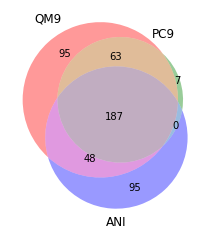

In [6]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline

venn3([QM9_missing, PC9_missing, ANI_missing], ('QM9', 'PC9', 'ANI'))1000
plt.show()


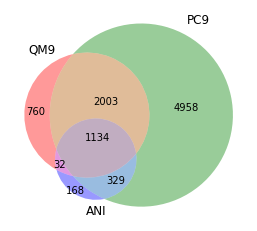

In [4]:
venn3([QM9_anons, PC9_anons, ANI_anons], ('QM9', 'PC9', 'ANI'))
plt.show()

In [5]:
import os
import subprocess

TB_amons = set()

df = pd.read_csv("databases/PC9_cleaned.csv")

for key, a in zip(df.key, df.Smiles_A):
    stream = os.popen("  {}".format(a))
    output = stream.read()   
    process = subprocess.Popen(['python', '/home/boittier/Documents/Amons/generate_amons.py', "{}".format(a)],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    stdout = [x.decode('UTF-8') for x in stdout.split()[1:]]
    
    assert len(stdout) > 1, [a, stderr]
    
    for x in stdout:
        TB_amons.add(x)
        
TB_amon_keys = list(TB_amons)
TB_amon_keys.sort()


In [6]:
import numpy as np

amons = []


for key, a in zip(df.key, df.Smiles_A):
    
    result = np.zeros(len(TB_amon_keys))
    
    stream = os.popen("  {}".format(a))
    output = stream.read()   
    process = subprocess.Popen(['python', '/home/boittier/Documents/Amons/generate_amons.py', "{}".format(a)],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    stdout = [x.decode('UTF-8') for x in stdout.split()[1:]]
    
    assert len(stdout) > 1, [a, stderr]
    
    for x in stdout:
        result[TB_amon_keys.index(x)] = 1
    amons.append(result)
    
 

In [7]:
df = pd.read_csv("databases/PC9_cleaned.csv")
amons = np.array(amons)1000
amons_df = pd.DataFrame(data=amons, columns=TB_amon_keys)
result = pd.concat([df, amons_df], axis=1, sort=False)
result.to_csv("databases/PC9_cleaned_amons.csv", index=False)

df = pd.read_csv("databases/QM9_cleaned.csv")
amons = np.array(amons)
amons_df = pd.DataFrame(data=amons, columns=TB_amon_keys)
result = pd.concat([df, amons_df], axis=1, sort=False)
result.to_csv("databases/QM9_cleaned_amons.csv", index=False)

df = pd.read_csv("databases/ANI1_cleaned.csv")
amons = np.array(amons)
amons_df = pd.DataFrame(data=amons, columns=TB_amon_keys)
result = pd.concat([df, amons_df], axis=1, sort=False)
result.to_csv("databases/ANI1_cleaned_amons.csv", index=False)

df = pd.read_csv("databases/ANI1x_cleaned.csv")
amons = np.array(amons)
amons_df = pd.DataFrame(data=amons, columns=TB_amon_keys)
result = pd.concat([df, amons_df], axis=1, sort=False)
result.to_csv("databases/ANI1x_cleaned_amons.csv", index=False)

df = pd.read_csv("databases/ANIE_cleaned.csv")
amons = np.array(amons)
amons_df = pd.DataFrame(data=amons, columns=TB_amon_keys)
result = pd.concat([df, amons_df], axis=1, sort=False)
result.to_csv("databases/ANIE_cleaned_amons.csv", index=False)


In [8]:
column_indexes = [False]*len(result.columns)

for x in range(19, len(result.columns)):
    column_indexes[x] = True

error_mols = result[abs(result.Diff_NN_abi) >= 1].iloc[:, column_indexes]
error_mols_amon_count = error_mols.sum(axis = 0)

regular_amons_count = result.iloc[:, column_indexes].sum(axis=0)

"""
Dividing the number of the amon count in the error subset by the total count
"""
error_count_ratio = error_mols_amon_count/regular_amons_count
"""
Then only print the 'rare' amons, test to see if they are in the traing set or not
"""

count_F = 0
count = 0
for a, x in error_count_ratio[error_count_ratio >= 0.85].iteritems():
    if a in ANI_anons:
        print("T - {:.4f} %".format(ANI_amon_counts[ANI_amon_keys.index(a)]*100/sum(ANI_amon_counts)), "\t\t", a)
    else:
        print("F - 0.0000 %","\t\t", a)
        count_F += 1
    count += 1
        
print()
print(count_F*100/count, " % ", count)

    


T - 0.4540 % 		 C#C
T - 0.0185 % 		 C(C#C)C=N
F - 0.0000 % 		 C([NH+]=O)C=N
F - 0.0000 % 		 C([NH3+])C=N
F - 0.0000 % 		 C([NH3+])C=O
F - 0.0000 % 		 C/C=C/O
F - 0.0000 % 		 C/C=N/C=O
F - 0.0000 % 		 C/N=C/C
F - 0.0000 % 		 C/N=C/C=C
F - 0.0000 % 		 C/N=C/C[NH3+]
F - 0.0000 % 		 C/N=C/[CH2]
T - 0.0001 % 		 C1NC=CN1
T - 0.0034 % 		 C1NCC=N1
T - 0.0163 % 		 C1NCCN1
T - 0.0173 % 		 C1NCCO1
T - 0.0430 % 		 C=CCC#C
F - 0.0000 % 		 C=CCC[NH3+]
T - 0.0001 % 		 C=CN=C[NH3+]
F - 0.0000 % 		 C=CNC#N
T - 0.0064 % 		 C=CNN=N
T - 0.0172 % 		 C=CN[C]=N
F - 0.0000 % 		 C=CN[NH+]=O
F - 0.0000 % 		 C=CN[NH3+]
T - 0.0316 % 		 C=COC=C
T - 0.0104 % 		 C=CO[C]=N
T - 0.0097 % 		 C=CO[C]=O
T - 0.0083 % 		 C=C[CH]C=C
T - 0.0170 % 		 C=C[C]=N
T - 0.0100 % 		 C=NCC=N
F - 0.0000 % 		 C=N[CH]N=C
T - 0.4366 % 		 CC#C
F - 0.0000 % 		 CC/C=C/O
F - 0.0000 % 		 CC/C=N/C
F - 0.0000 % 		 CC/N=C/C
T - 0.0366 % 		 CC=CC#N
T - 0.0014 % 		 CC=C[CH]N
F - 0.0000 % 		 CC=C[NH+]=O
F - 0.0000 % 		 CC=C[NH3+]
T - 0.0032 % 		 CC=N

In [9]:
result.columns[:19]

Index(['key', 'Unnamed: 0', 'Smiles_A', 'Smiles_B', 'natoms', 'Ea_DFT',
       'Ea_nn', 'Diff_MolA', 'Eb_DFT', 'Eb_nn', 'Diff_molB', 'Diff_abi',
       'Diff_NN', 'Diff_NN_abi', 'heavy_atoms', 'NHOHs', 'NOs',
       'hetero_arom_rings', 'rings'],
      dtype='object')

In [11]:
result

,key,Unnamed: 0,Smiles_A,Smiles_B,natoms,Ea_DFT,Ea_nn,Diff_MolA,Eb_DFT,Eb_nn,...,c1cnno1,c1cnon1,c1ncc[nH]1,c1ncco1,c1ncn[nH]1,c1ncno1,c1nnn[nH]1,c1nnno1,n1ncno1,o1cnnc1
0,a_1,0,O=C1NCC=C1,O=C1NC=CC1,6.0,-1192.335066,-1192.354796,0.019730,-1192.212429,-1192.137772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a_2,1,CN(CC=C1)C1=O,CN(C=CC1)C1=O,7.0,-1488.708260,-1488.817400,0.109140,-1488.437243,-1488.293622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,a_4,3,O=C1OC=CC1,O=C1OCC=C1,6.0,-1122.510203,-1122.487384,-0.022819,-1124.268723,-1124.216976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a_5,4,O=C1OC(c2ccccc2)=CC1,O=C(C=C1)OC1c1ccccc1,12.0,-2389.246059,-2381.728792,-7.517267,-2385.626068,-2375.421114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a_6,5,O=C1OCC=C1,O=C1OC=CC1,6.0,-1124.268723,-1124.217152,-0.051571,-1122.510226,-1122.485888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,a_1253,1250,O=C1N=CNC1,Oc1c[nH]cn1,6.0,-1067.564312,-1067.357884,-0.206427,-1058.921202,-1059.018875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
956,a_1197,1251,Oc1c[nH]cn1,O=C1NC=NC1,6.0,-1058.921202,-1059.018963,0.097761,-1073.326696,-1073.331537,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
957,a_1255,1252,Nc1nc(O)c[nH]1,NC(N1)=NCC1=O,7.0,-1236.746128,-1236.818460,0.072332,-1253.080540,-1253.734000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
958,a_1256,1253,Oc1nnnc2ccccc12,O=C1NN=Nc2c1cccc2,11.0,-1878.277466,-1863.431796,-14.845670,-1892.817349,-1879.483640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
result[result["C([NH+]=O)C=N"] == 1]

,key,Unnamed: 0,Smiles_A,Smiles_B,natoms,Ea_DFT,Ea_nn,Diff_MolA,Eb_DFT,Eb_nn,...,c1cnno1,c1cnon1,c1ncc[nH]1,c1ncco1,c1ncn[nH]1,c1ncno1,c1nnn[nH]1,c1nnno1,n1ncno1,o1cnnc1
383,a_516,515,CC/N=C/C[N+]([O-])=O,CCN/C=C/[N+]([O-])=O,8.0,-1528.992226,-1533.416978,4.424752,-1530.289643,-1533.579021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
